In [24]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from ray import tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler
from ray.tune import CheckpointConfig
from ray.tune.search.basic_variant import BasicVariantGenerator
import matplotlib.pyplot as plt
import pandas as pd
import re


import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')


In [2]:
import gc
gc.collect()

import torch

torch.cuda.empty_cache()

In [3]:
import ray
ray.init()
print(ray.available_resources()) 

2025-03-06 22:43:25,021	INFO worker.py:1841 -- Started a local Ray instance.


{'node:__internal_head__': 1.0, 'CPU': 64.0, 'memory': 852766956544.0, 'accelerator_type:RTX': 1.0, 'object_store_memory': 200000000000.0, 'GPU': 8.0, 'node:192.168.60.144': 1.0}


In [4]:
import ray
ray.shutdown()
ray.init(runtime_env={"working_dir": "/home/mei/nas/docker/thesis/model_train"})
ray.init(ignore_reinit_error=True, _temp_dir="/home/mei/nas/docker/thesis/data/ray_results")


2025-03-06 22:43:30,857	INFO worker.py:1841 -- Started a local Ray instance.
2025-03-06 22:43:30,903	INFO packaging.py:575 -- Creating a file package for local module '/home/mei/nas/docker/thesis/model_train'.
2025-03-06 22:43:30,957	INFO packaging.py:367 -- Pushing file package 'gcs://_ray_pkg_6560cf3e78af6e56.zip' (1.72MiB) to Ray cluster...
2025-03-06 22:43:30,964	INFO packaging.py:380 -- Successfully pushed file package 'gcs://_ray_pkg_6560cf3e78af6e56.zip'.
2025-03-06 22:43:31,754	INFO worker.py:1672 -- Calling ray.init() again after it has already been called.


Python version:,3.10.14
Ray version:,2.43.0


(train_autoencoder pid=868828) Epoch 1/10, Validation Loss: 0.0409
(train_autoencoder pid=868825) Epoch 1/10, Validation Loss: 0.1579
(train_autoencoder pid=868827) Epoch 1/10, Validation Loss: 0.0793
(train_autoencoder pid=868827) Epoch 2/10, Validation Loss: 0.0451 [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(train_autoencoder pid=868825) Epoch 2/10, Validation Loss: 0.1533
(train_autoencoder pid=868828) Epoch 2/10, Validation Loss: 0.0307
(train_autoencoder pid=868825) Epoch 3/10, Validation Loss: 0.1481 [repeated 2x across cluster]
(train_autoencoder pid=868827) Epoch 3/10, Validation Loss: 0.0359
(train_autoencoder pid=868826) Epoch 3/10, Validation Loss: 0.1095
(train_autoencoder pid=868825) Epoch 4/10, Validation Loss: 0.1415 [repeated 2x across cluster]
(train_autoencoder pid=868826)

In [5]:
from dataloader.ts_reader import MultiModalDataset, collate_fn_pre_train
from model.autoencoder_ts import TimeSeriesAutoencoder

In [6]:
def train_autoencoder(config, train_loader, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = TimeSeriesAutoencoder(
        input_dim=config["input_dim"],
        hidden_dim=config["hidden_dim"],
    ).to(device)
    
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    
    best_val_loss = float("inf")
    model_dir= "/home/mei/nas/docker/thesis/data/model/pre_train_autoencoder"  
    os.makedirs(model_dir, exist_ok=True)
    best_model_path = os.path.join(model_dir, "best_model.pth")
    
    for epoch in range(config["epochs"]):
        model.train()
        for batch in train_loader:
            inputs, lengths = batch
            inputs = inputs.to(device)
            lengths = lengths.to(device)
            optimizer.zero_grad()
            outputs, _ = model(inputs, lengths)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                inputs, lengths = batch
                inputs = inputs.to(device)
                lengths = lengths.to(device)
                outputs, _ = model(inputs, lengths)
                loss = criterion(outputs, inputs)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1}/{config['epochs']}, Validation Loss: {val_loss:.4f}")
        tune.report({"val_loss": val_loss})
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
    
    print(f"Best validation loss: {best_val_loss}")
    
    

In [11]:
def tune_autoencoder(train_loader, val_loader):
    search_space = {
        "input_dim": 324, 
        "hidden_dim": tune.grid_search([32, 64]),
        "lr": tune.grid_search([1e-5, 1e-4, 1e-3]), 
        "epochs": 10,
    }
    
    algo = BasicVariantGenerator()  # 使用网格搜索
    scheduler = ASHAScheduler(
        max_t=10,  
        grace_period=5,  
        reduction_factor=2, 
    )
    tuner = tune.Tuner(
        tune.with_resources(
        tune.with_parameters(train_autoencoder, train_loader=train_loader, val_loader=val_loader),
        resources={"cpu": 4, "gpu": 2}  
    ),
        tune_config=tune.TuneConfig(
            metric="val_loss",
            mode="min",
            search_alg=algo,
            scheduler=scheduler,
        ),
        run_config=tune.RunConfig(
            stop={"training_iteration": 10},  # 
            name="pre_train_autoencoder", 
            storage_path="/home/mei/nas/docker/thesis/data/ray_results/pre_train_autoencoder",
        ),
        param_space=search_space,
    )

    results = tuner.fit()
    best_config = results.get_best_result().config

    print("Best Hyperparameters:", best_config)
    return best_config


In [8]:
train_data_dir = "/home/mei/nas/docker/thesis/data/hdf/train"
val_data_dir = "/home/mei/nas/docker/thesis/data/hdf/val"

lstm_dataset_train = MultiModalDataset(train_data_dir)
lstm_dataset_val = MultiModalDataset(val_data_dir)

lstm_loader_train = DataLoader(lstm_dataset_train, batch_size=32, shuffle=True, collate_fn=collate_fn_pre_train)
lstm_loader_val = DataLoader(lstm_dataset_val, batch_size=32, shuffle=False,collate_fn=collate_fn_pre_train)

In [12]:
best_params = tune_autoencoder(lstm_loader_train,lstm_loader_val)

2025-03-07 14:53:07,624	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/mei/nas/docker/thesis/data/ray_results/pre_train_autoencoder/pre_train_autoencoder' in 0.0449s.
2025-03-07 14:53:07,633	INFO tune.py:1041 -- Total run time: 57801.46 seconds (57801.37 seconds for the tuning loop).


Best Hyperparameters: {'input_dim': 324, 'hidden_dim': 32, 'lr': 0.0001, 'epochs': 10}


In [34]:

import math

def plot_loss(results_dir):
 
    trial_dirs = [d for d in os.listdir(results_dir) if os.path.isdir(os.path.join(results_dir, d))]

    trial_data = []
    for trial_dir in trial_dirs:
        trial_path = os.path.join(results_dir, trial_dir)
        progress_path = os.path.join(trial_path, "progress.csv")

        if os.path.isfile(progress_path):
            df = pd.read_csv(progress_path)
            if "training_iteration" in df.columns and "val_loss" in df.columns:
                hidden_dim_match = re.search(r"hidden_dim=(\d+)", trial_dir)
                lr_match = re.search(r"lr=([\d.]+)", trial_dir)

                if hidden_dim_match and lr_match:
                    hidden_dim = int(hidden_dim_match.group(1))
                    lr = float(lr_match.group(1))

                    trial_data.append({
                        "hidden_dim": hidden_dim,
                        "lr": lr,
                        "dir": trial_dir,
                        "df": df
                    })

    trial_data.sort(key=lambda x: (-x["hidden_dim"], x["lr"]))

    hidden_dims = sorted(set(d["hidden_dim"] for d in trial_data), reverse=True)
    lrs = sorted(set(d["lr"] for d in trial_data))

    num_rows = len(hidden_dims)
    num_cols = len(lrs)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows), sharex=True, sharey=False)
    if num_rows == 1 and num_cols == 1:
        axes = [[axes]]
    elif num_rows == 1:
        axes = [axes]
    elif num_cols == 1:
        axes = [[ax] for ax in axes]

    for trial in trial_data:
        hidden_dim = trial["hidden_dim"]
        lr = trial["lr"]
        df = trial["df"]

        row_idx = hidden_dims.index(hidden_dim)
        col_idx = lrs.index(lr)

        ax = axes[row_idx][col_idx]
        ax.plot(df["training_iteration"], df["val_loss"], label="Validation Loss", color="skyblue", linewidth=2)

        ax.set_title(f"hidden_dim={hidden_dim}, lr={lr}")
        if row_idx == num_rows - 1:
            ax.set_xlabel("Epoch")
        if col_idx == 0:
            ax.set_ylabel("Validation Loss")

        ax.grid(True)

    plt.tight_layout()

    plt.show()

    plt.close()




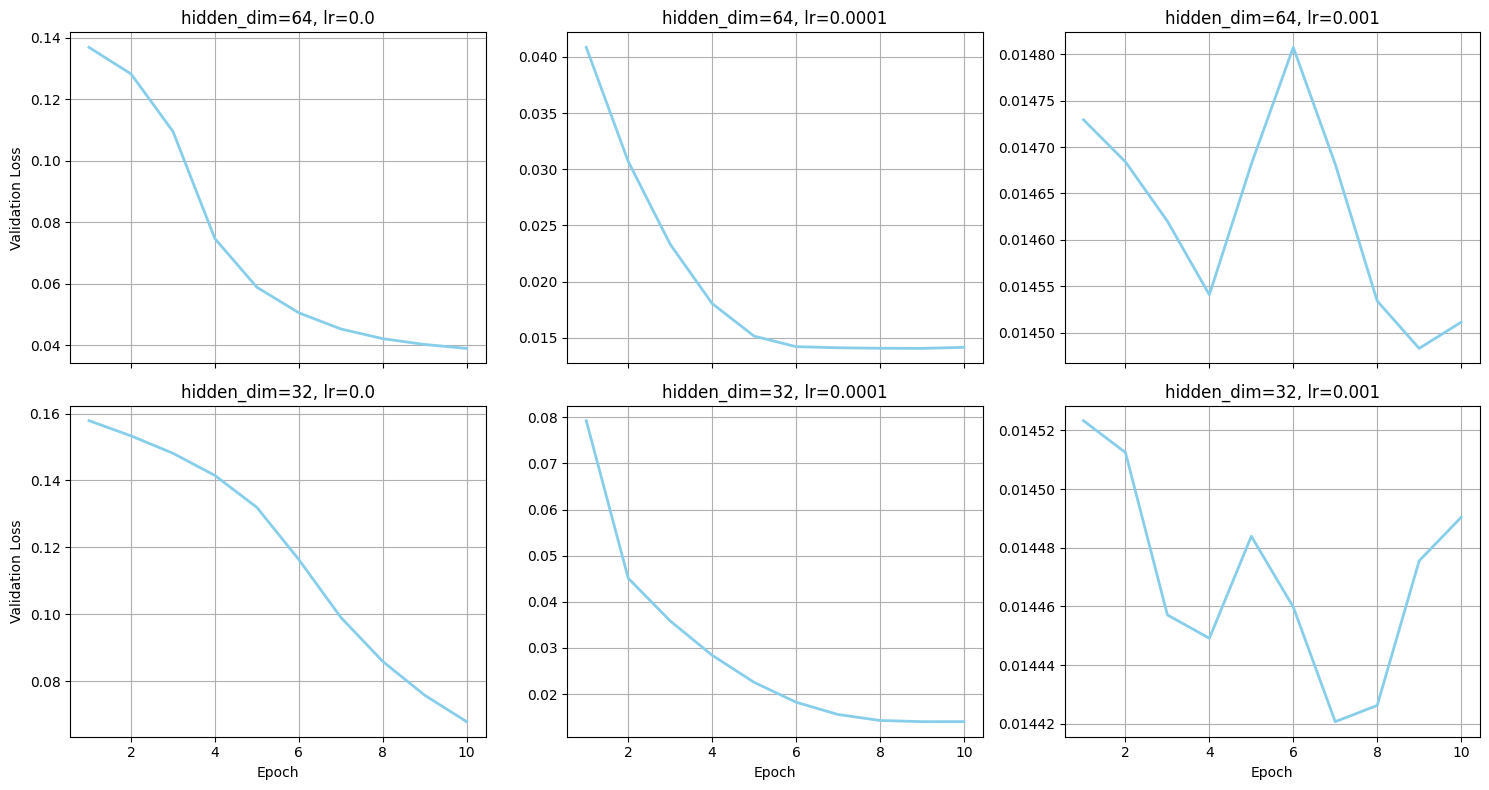

In [35]:
trial_dir = "/home/mei/nas/docker/thesis/data/ray_results/pre_train_autoencoder/pre_train_autoencoder"
plot_loss(trial_dir)